## Step 1: Library import

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
from sklearn.pipeline import Pipeline
from sklearn.datasets import fetch_openml
from sklearn.metrics import confusion_matrix
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

from sklearn.model_selection import train_test_split

from sklearn import svm
from sklearn.model_selection import GridSearchCV

#import xray_data #y data: 1 = NORMAL, 0 = PNEUMONIA
import random

random.seed(207)

In [2]:
import NIHCC_xray_data


86524 images in training set
25596 images in test set
valid tags for dataset:  ['Cardiomegaly', 'No Finding', 'Hernia', 'Infiltration', 'Nodule', 'Emphysema', 'Effusion', 'Atelectasis', 'Mass', 'Pneumothorax', 'Pleural_Thickening', 'Fibrosis', 'Consolidation', 'Edema', 'Pneumonia']


## Step 2: Load and preprocess data
Note: data is resized and preprocessed as it is read, as a memory optimization.

In [3]:
#Constants
scale = 200
# Kaggle data options
#label_filter = ['NORMAL','PNEUMONIA','COVID19','TURBERCULOSIS']
#NIHCC options
label_filter = ['Cardiomegaly', 'No Finding', 'Hernia', 'Infiltration', 
                'Nodule', 'Emphysema', 'Effusion', 'Atelectasis', 
                'Mass', 'Pneumothorax', 'Pleural_Thickening', 'Fibrosis',
                'Consolidation', 'Edema', 'Pneumonia']
subset = 'PROP' # either "EQL" or "PROP"

In [4]:
# cut of for training samples of each class, only 230 normal rows
test_cutoff =1000

X_test, y_test = NIHCC_xray_data.load_test(scale,label_filter,test_cutoff,subset=subset)
print(f'X_test, y_test shape: {X_test.shape, y_test.shape}')
print(f'y_test shape for NORMAL cases: {y_test[y_test ==1].shape}')
print('----')

100% (17853 of 17853) |##################| Elapsed Time: 0:00:50 Time:  0:00:50


Hernia: 2
Mass: 24
Pneumothorax: 53
No Finding: 552
Emphysema: 17
Cardiomegaly: 17
Infiltration: 124
Pleural_Thickening: 17
Effusion: 65
Consolidation: 26
Edema: 12
Atelectasis: 44
Fibrosis: 9
Pneumonia: 4
Nodule: 25
Total: 991
X_test, y_test shape: ((991, 40000), (991,))
y_test shape for NORMAL cases: (552,)
----


In [5]:
# cut of for training samples of each class, only 1300 normal rows
train_cutoff = 10000

X_train, y_train = NIHCC_xray_data.load_train(scale,label_filter,max_count=train_cutoff,subset=subset)


100% (73471 of 73471) |##################| Elapsed Time: 0:09:16 Time:  0:09:16


Cardiomegaly: 105
No Finding: 6873
Infiltration: 997
Nodule: 305
Emphysema: 79
Effusion: 379
Atelectasis: 464
Pleural_Thickening: 111
Fibrosis: 74
Mass: 230
Pneumonia: 31
Pneumothorax: 168
Hernia: 8
Consolidation: 112
Edema: 54
Total: 9990


#### Step2a: Adjust all image sets by mean/std of train

In [6]:
#(mean,std) = xray_data.find_mean_std(X_train)
#print(mean,std)
#print(X_train.shape)
#adjusted_X_train = xray_data.normalize_images(X_train,mean,std)
#print (f'adjusted train {adjusted_X_train.shape}')
#adjusted_X_dev_org = xray_data.normalize_images(X_dev_orig,mean,std)
#adjusted_X_test = xray_data.normalize_images(X_test,mean,std)
# uncomment to use rescaled data
# X_train = adjusted_X_train
# X_dev_org = adjusted_X_dev_orig
# X_test = adjusted_X_test

### Step 2b: Split data into dev and train
Original dev data set is too small for much validity


In [7]:
# I'm not sure what the final stratify parameter is doing.  We'll want to revist when we do full cross validation

X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size = .1, stratify = y_train )
print(f'X_train, y_train shape: {X_train.shape, y_train.shape}')
print(f'y_train shape for NORMAL cases: {y_train[y_train ==1].shape}')
print('----')
print(f'X_dev, y_dev shape: {X_dev.shape, y_dev.shape}')
print(f'y_dev shape for NORMAL cases: {y_dev[y_dev ==1].shape}')

X_train, y_train shape: ((8991, 40000), (8991,))
y_train shape for NORMAL cases: (6186,)
----
X_dev, y_dev shape: ((999, 40000), (999,))
y_dev shape for NORMAL cases: (687,)


## Step 3: Single Model training

Default values:  The default model for SVC is 
 - C=1, 
 - kernel='rbf', 
 - gamma=1/(n_features * X.var()).  For a 200x200 rescale this results in gamma = .000025/X.var().  We may want to go with smaller gamma values.



In [8]:

base_model = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(5,2), max_iter = 1000, random_state=1)

base_model.fit(X_train,y_train)



/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), max_iter=1000,
              random_state=1, solver='lbfgs')

In [9]:
y_pred_b = base_model.predict(X_dev)

In [10]:
print(f'Single Model accuracy: {accuracy_score(y_pred_b,y_dev)*100:9.5}')
f1score = f1_score(y_pred_b,y_dev,average='weighted')

print(f'Single Model f1_score: {f1score*100:9.5}')

Single Model accuracy:    54.154
Single Model f1_score:    56.854


## Step 4  CrossValidated Gridsearch models

In [11]:
parameters = {'solver': ['lbfgs'],
              'activation': ['identity', 'logistic'],
              'hidden_layer_sizes': [(5,2), (5,)],
              'alpha': [0.1, 0.0001],
              'max_iter': [1000, 1500]
             }
mlpc = MLPClassifier()
CV_model = GridSearchCV(mlpc,parameters,verbose=3)

CV_model.fit(X_train,y_train)


Fitting 5 folds for each of 16 candidates, totalling 80 fits


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.513 total time=14.6min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.555 total time=14.7min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.547 total time=14.8min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.542 total time=14.6min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.563 total time=14.3min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.497 total time=21.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.527 total time=21.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.508 total time=21.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.508 total time=21.8min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.538 total time=22.0min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.529 total time=13.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.540 total time=14.3min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.525 total time=14.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.528 total time=14.6min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.538 total time=14.0min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.529 total time=21.1min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.511 total time=21.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.518 total time=21.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.531 total time=21.0min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.522 total time=21.1min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.519 total time=14.6min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.520 total time=14.3min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.519 total time=14.6min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.532 total time=14.7min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.592 total time=14.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.522 total time=21.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.523 total time=21.8min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.522 total time=21.7min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.518 total time=21.8min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.552 total time=21.5min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.524 total time=13.8min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.544 total time=13.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.549 total time=13.8min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.542 total time=14.3min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.551 total time=13.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.532 total time=21.3min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.521 total time=20.7min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.526 total time=21.0min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.527 total time=21.1min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=identity, alpha=0.0001, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.522 total time=21.3min
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.688 total time=  35.1s
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.688 total time=  31.3s


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.678 total time=14.5min
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.688 total time=  20.8s
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.689 total time=  19.2s


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.590 total time=22.2min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.613 total time=21.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.645 total time=22.1min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.553 total time=22.1min
[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.689 total time=  19.1s


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.589 total time=14.9min
[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.688 total time=  28.5s
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.688 total time=  28.2s
[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.687 total time= 4.4min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1000, solver=lbfgs;, score=0.583 total time=14.8min
[CV 1/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.688 total time=  30.7s


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.684 total time=21.6min
[CV 3/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.688 total time= 1.9min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 4/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.579 total time=22.3min


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 5/5] END activation=logistic, alpha=0.1, hidden_layer_sizes=(5,), max_iter=1500, solver=lbfgs;, score=0.594 total time=21.9min
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.688 total time=  20.4s


/home/arm/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.546 total time=14.9min
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.688 total time= 1.6min
[CV 4/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.688 total time=  19.8s
[CV 5/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1000, solver=lbfgs;, score=0.689 total time=  18.5s
[CV 1/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.687 total time= 6.6min
[CV 2/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.685 total time=17.1min
[CV 3/5] END activation=logistic, alpha=0.0001, hidden_layer_sizes=(5, 2), max_iter=1500, solver=lbfgs;, score=0.688 total time= 1.8min
[CV 4/5] END activation=logistic, alpha=0.0001, 

GridSearchCV(estimator=MLPClassifier(),
             param_grid={'activation': ['identity', 'logistic'],
                         'alpha': [0.1, 0.0001],
                         'hidden_layer_sizes': [(5, 2), (5,)],
                         'max_iter': [1000, 1500], 'solver': ['lbfgs']},
             verbose=3)

In [12]:
print(f'Best score: {CV_model.best_score_*100:9.5}')
print(f'Best params: {CV_model.best_params_}')

Best score:    68.802
Best params: {'activation': 'logistic', 'alpha': 0.0001, 'hidden_layer_sizes': (5,), 'max_iter': 1000, 'solver': 'lbfgs'}


In [13]:
y_pred = CV_model.predict(X_dev)

In [14]:
print(f'Best Fit Model accuracy: {accuracy_score(y_pred,y_dev)*100:9.5}')

f1score = f1_score(y_pred,y_dev,average='weighted')

print(f'Best Fit Model f1_score: {f1score*100:9.5}')

Best Fit Model accuracy:    68.769
Best Fit Model f1_score:    81.495


Text(0, 0.5, 'True Label')

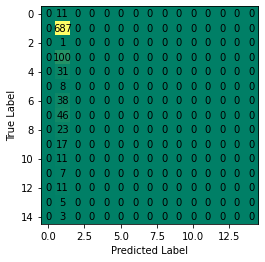

In [15]:
from sklearn.metrics import plot_confusion_matrix

grid = confusion_matrix(y_dev, y_pred)
plt.imshow(grid, cmap = 'summer')

for (j,i),label in np.ndenumerate(grid):
    plt.text(i,j,label,ha='center',va='center')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')